In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import Counter
from pathlib import Path
from matplotlib.ticker import MaxNLocator

sys.path.append("../helpers/")
from impresso_id import *

data_path = "data"

sns.set()

%load_ext autoreload
%autoreload 2

# Manually tagged tables

In [2]:
df = pd.read_parquet(os.path.join(data_path, "NLL_tag_lite.parquet"))

## Exploration

In [3]:
tagset = df['tag'].unique()
print(tagset)
journals = df['journal'].unique()
print(journals)

['transport schedule' 'stock' 'currency rates' 'sport results'
 'food prices' 'weather' 'lotto' 'not a table' 'miscellaneous' 'radio'
 'election' 'cinema']
['luxwort' 'dunioun' 'lunion' 'obermosel' 'avenirgdl' 'luxzeit1858'
 'waechtersauer' 'courriergdl' 'volkfreu1869' 'luxland' 'buergerbeamten'
 'armeteufel' 'schmiede' 'gazgrdlux' 'diekwochen' 'demitock']


In [4]:
tag_color_palette = sns.color_palette(n_colors=len(tagset) + 1)
tag_colors = {'stock': tag_color_palette[0], 
             'transport schedule': tag_color_palette[1], 
             'food prices': tag_color_palette[2], 
             'currency rates': tag_color_palette[3], 
             'sport results': tag_color_palette[4], 
             'miscellaneous': tag_color_palette[5],
             'weather': tag_color_palette[6], 
             'not a table': tag_color_palette[7], 
             'radio': tag_color_palette[8],
             'election': tag_color_palette[9], 
             'lotto': tag_color_palette[10], 
             'cinema': tag_color_palette[11], 
             'remaining tags': 'snow'}

journal_colors = {'luxwort': 'gold', 
         'dunioun': 'blue', 
         'lunion': 'green',
         'obermosel': 'yellow',
         'avenirgdl': 'lime',
         'luxzeit1858': 'lightsteelblue',
         'waechtersauer': 'cyan',
         'courriergdl': 'magenta',
         'volkfreu1869': 'darkviolet',
         'luxland': 'lightcoral',
         'buergerbeamten': 'olive',
         'armeteufel': 'red',
         'schmiede': 'aquamarine',
         'gazgrdlux': 'maroon',
         'diekwochen': 'teal',
         'demitock': 'indigo',
         'remaining journals': 'purple'}

#### Tag distribution

In [5]:
df_count_per_tag = df.groupby('tag').count()['pid'].sort_values()

count_per_tag = {'remaining tags': 0}
for tag, count in df_count_per_tag.items():
    if count/sum(df_count_per_tag) < 0.018:
        count_per_tag['remaining tags'] += count
    else:
        count_per_tag[tag] = count

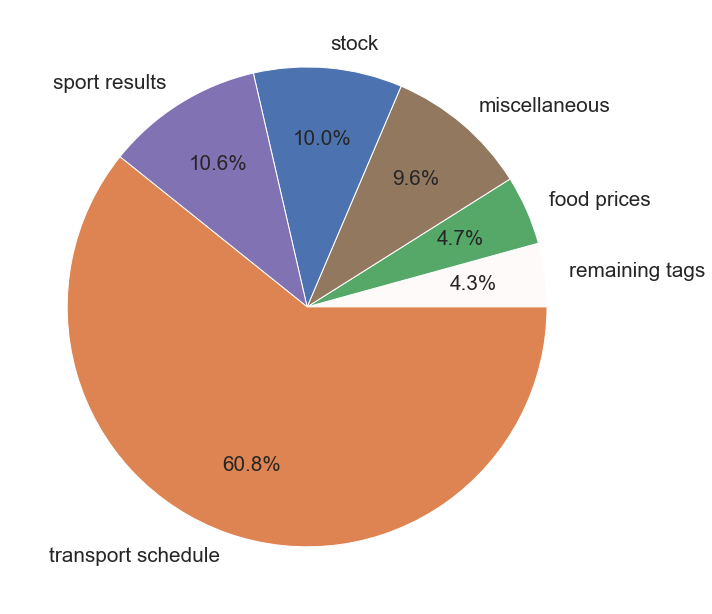

In [6]:
plt.figure(figsize=(10,10))
plt.pie(count_per_tag.values(), labels=list(count_per_tag.keys()), 
        colors=[tag_colors[k] for k, v in count_per_tag.items()], 
        autopct='%.1f%%', pctdistance=0.7, textprops={'fontsize': 'xx-large'})
plt.tight_layout()
plt.show()

#### Tag distribution over time

In [7]:
df_pid_tag = df.groupby('pid').agg(set)['tag']

tag_page_year = {}
for pid, tags in df_pid_tag.items():
    year = get_year(pid)
    if year not in tag_page_year:
        tag_page_year[year] = Counter()
    tag_page_year[year].update(Counter(tags))

years = range(min(df['year']), max(df['year']) + 1)
for year in years:
    if year not in tag_page_year:
        tag_page_year[year] = Counter()

/Users/assa/opt/miniconda3/envs/pdm/lib/python3.9/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


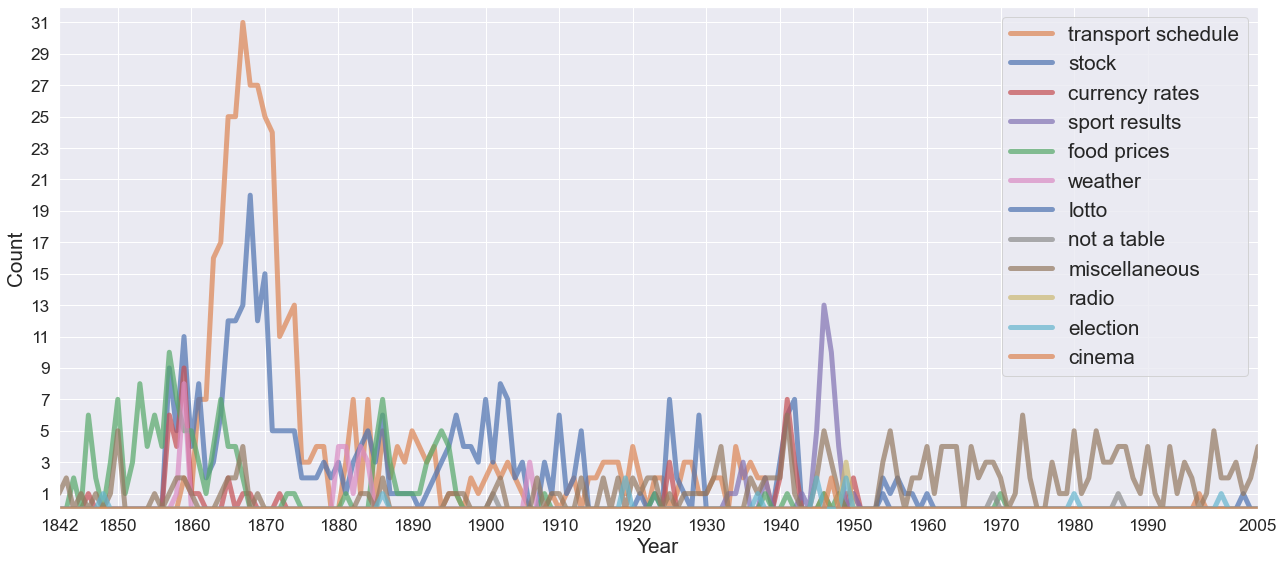

In [8]:
fig, ax = plt.subplots(figsize=(18, 8))
for tag in tagset:
    sns.lineplot(x=tag_page_year.keys(), y=[k[tag] if tag in k else 0 for k in tag_page_year.values()], 
                color=tag_colors[tag], label=tag, linewidth=5, alpha=0.7)
    
years = [years[0]] + list(range(1850, 2000, 10)) + [years[-1]]
ax.axes.xaxis.set_ticks(years) 

ax.axes.yaxis.set_ticks(np.arange(1, 32, 2)) 

ax.margins(x=0, y=0)
#ax.set_ylim([0, 100])
ax.tick_params(axis='both', which='major', labelsize='x-large')
plt.ylim([0, 32])
plt.legend(fontsize='xx-large')
plt.xlabel('Year', fontsize='xx-large')
plt.ylabel('Count', fontsize='xx-large')
plt.tight_layout()
plt.show()

In [9]:
df_per_year = df.groupby(['year', 'tag']).count().reset_index()
years = range(min(df['year']), max(df['year']) + 1)
df_years = pd.Series(0, index=years)

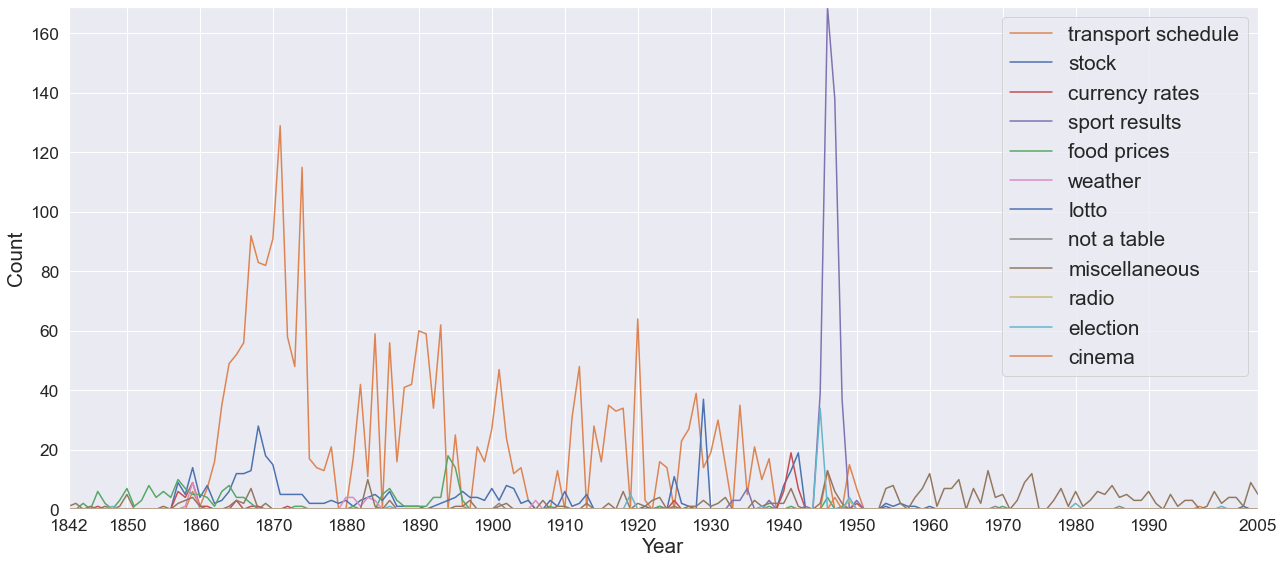

In [10]:
fig, ax = plt.subplots(figsize=(18, 8))
for tag in tagset:
    df_tmp = df_per_year.loc[df_per_year['tag'] == tag, ['year', 'pid']].set_index('year')
    df_tmp = df_years.combine(df_tmp['pid'], lambda x, y: max(x, y))
    plt.plot(df_tmp.index, df_tmp.values, label=tag, color=tag_colors[tag])
    
years = [years[0]] + list(range(1850, 2000, 10)) + [years[-1]]
ax.axes.xaxis.set_ticks(years) 


ax.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', labelsize='x-large')

plt.legend(fontsize='xx-large')
plt.xlabel('Year', fontsize='xx-large')
plt.ylabel('Count', fontsize='xx-large')
plt.tight_layout()
plt.show()

#### Tag distribution per journal

In [11]:
df_journal_tag_per_year = df.groupby(['year', 'tag', 'journal']).count().reset_index()
years = range(min(df['year']), max(df['year']) + 1)
df_years = pd.Series(0, index=years)

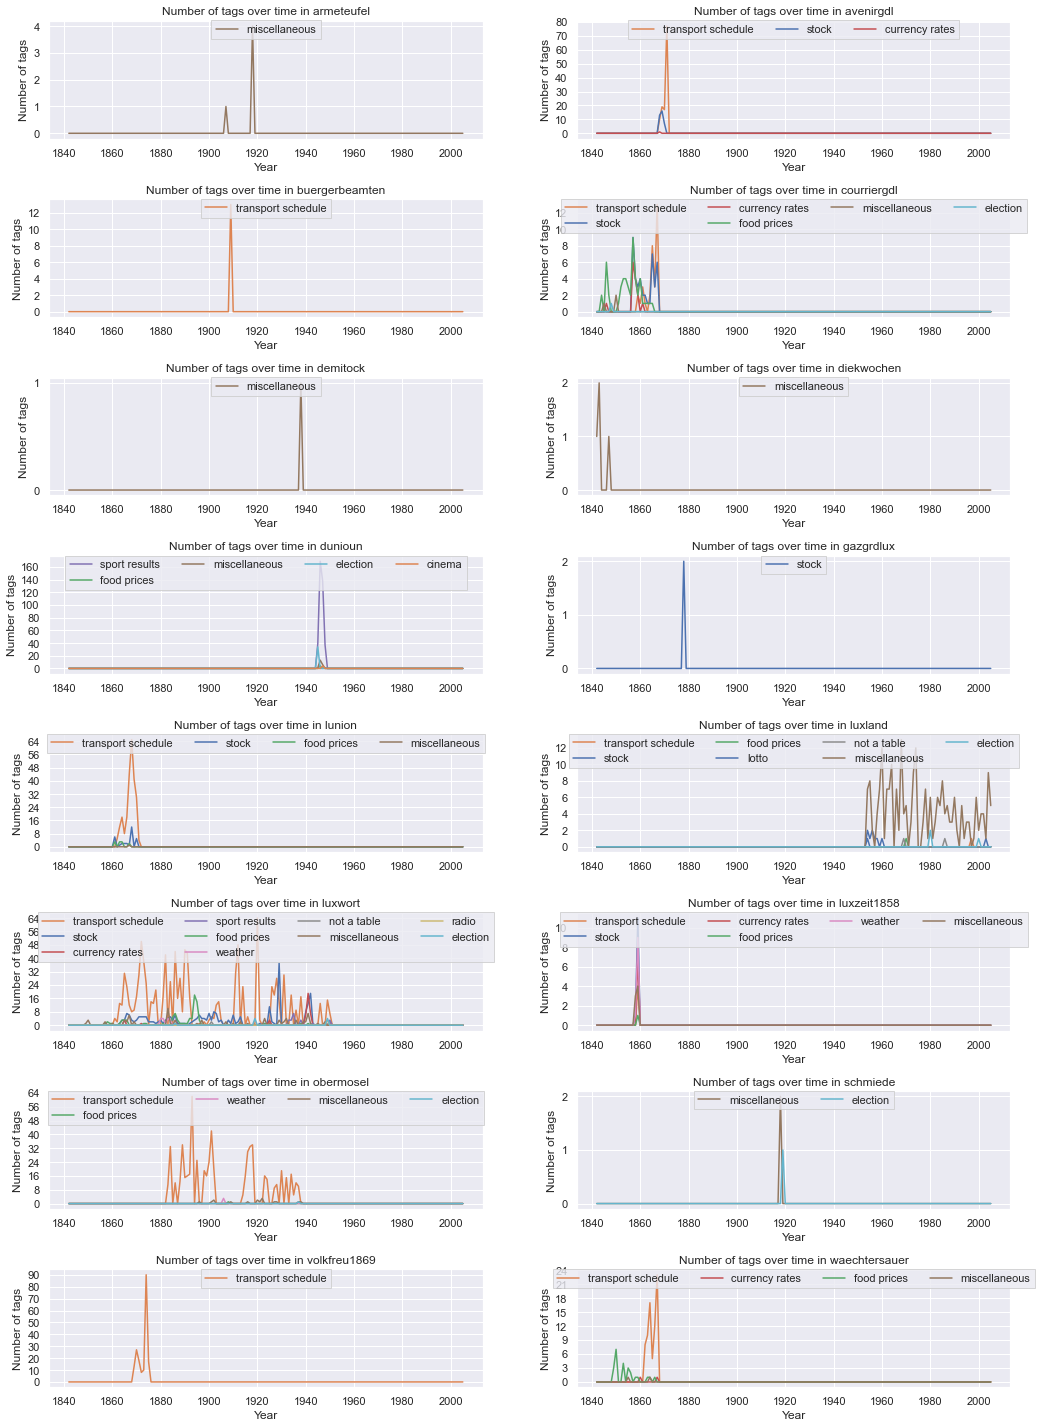

In [12]:
num_journals = len(df_journal_tag_per_year['journal'].unique())

plt.figure(figsize=(15,20))

i = 1
for journal in sorted(journals):
    if journal in df_journal_tag_per_year['journal'].unique():
        ax = plt.subplot(int(num_journals/2), 2, i)
        for tag in tagset:
            df_tmp = df_journal_tag_per_year.loc[(df_journal_tag_per_year['tag'] == tag) & (df_journal_tag_per_year['journal'] == journal), ['year', 'pid']].set_index('year')
            df_tmp = df_years.combine(df_tmp['pid'], lambda x, y: max(x, y))
            if len(df_tmp[df_tmp > 0]) > 0:
                plt.plot(df_tmp.index, df_tmp.values, label=tag, color=tag_colors[tag])
                
        plt.title(f"Number of tags over time in {journal}")
        plt.xlabel("Year")
        plt.ylabel("Number of tags")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=False, shadow=False)
        i += 1

plt.tight_layout()
plt.show()

#### Tag page confusion

In [13]:
df_page = df.groupby('pid')['tag'].agg(set)
distr = {tag: [x for x in df_page.values if tag in x] for tag in tagset}

tags_count = {}
for tag1 in tagset:
    tags_count[tag1] = {}
    tag_distr = distr[tag1]
    tag1_count = len(tag_distr)
    for tag2 in tagset:
        tag2_count = len([x for x in tag_distr if tag2 in x])
        tags_count[tag1][tag2] = tag2_count/tag1_count
        
matrix = [[v2 for k2, v2 in v1.items()] for k1, v1 in tags_count.items()]

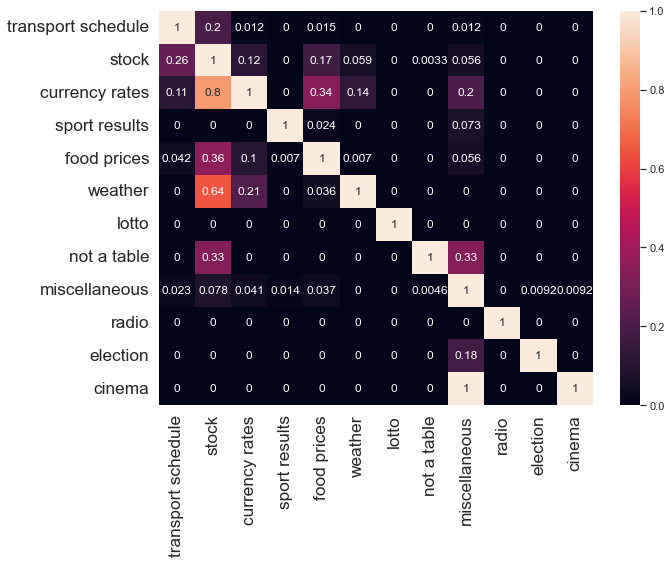

In [14]:
df_cm = pd.DataFrame(matrix, index=tagset, columns=tagset)
plt.figure(figsize = (10,8))
g = sns.heatmap(df_cm, annot=True, fmt='0.2g')
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 'x-large')
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 'x-large')
plt.tight_layout()
plt.show()

#### Tag size distribution

This part of the code necessits a file containing the sizes of the images of newspaper pages to correctly function. This file is automatically generated when downloading images using *download_images_from_s3.py*.

In [17]:
with open("NLL_metadata_images.json", "r") as f:
    metadata = json.load(f)

df["area"] = df.apply(lambda x: x["width"]*x["height"], axis=1)
df['area_normalized'] = df.apply(lambda x: 100*x['area']/(metadata[x['pid']]['height']*metadata[x['pid']]['width']) if x['pid'] in metadata else 0, axis=1)

In [18]:
df_area_sum_per_tag = df.groupby('tag').sum()['area_normalized'].sort_values()

area_sum_per_tag = {'remaining tags': 0}
for tag, count in df_area_sum_per_tag.items():
    if count/sum(df_area_sum_per_tag) < 0.012: #and area_sum_per_tag['remaining tags']/sum(df_area_sum_per_tag) < 0.02:
        area_sum_per_tag['remaining tags'] += count
    else:
        area_sum_per_tag[tag] = count

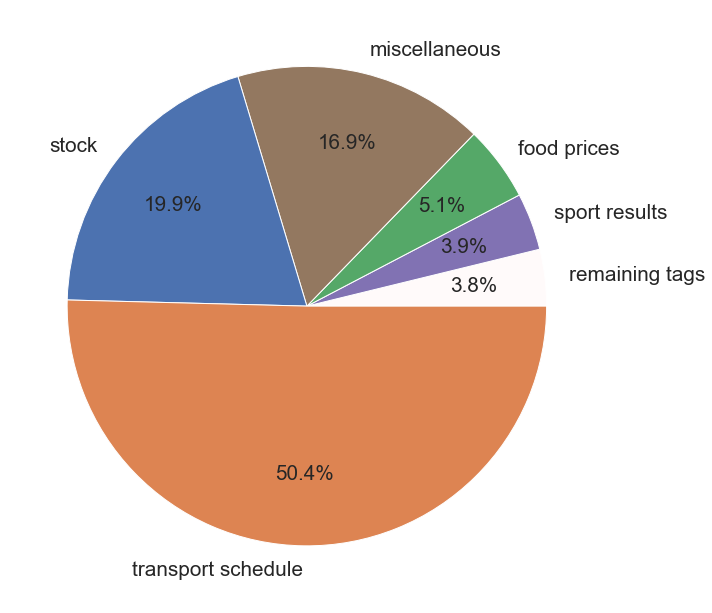

In [19]:
plt.figure(figsize=(10,10))
plt.pie(area_sum_per_tag.values(), labels=list(area_sum_per_tag.keys()), 
        colors=[tag_colors[k] for k, v in area_sum_per_tag.items()], 
        autopct='%.1f%%', pctdistance=0.7, textprops={'fontsize': 'xx-large'})

plt.tight_layout()
plt.show()

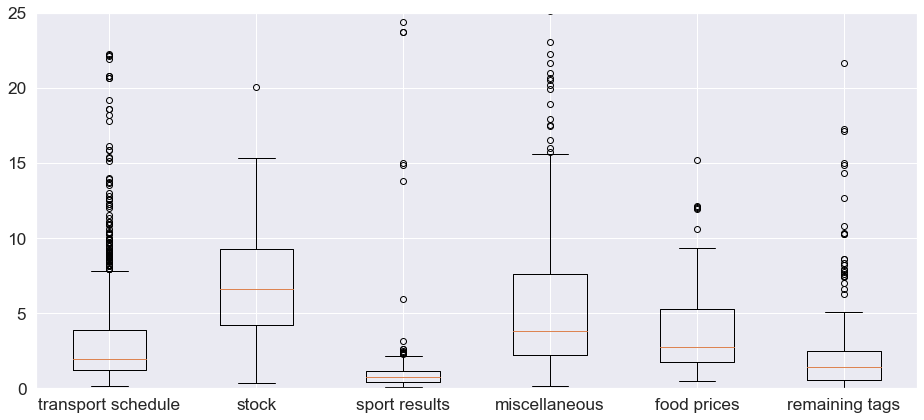

In [20]:
boxplots_data = []
tagset_tmp = ['transport schedule', 'stock', 'sport results', 'miscellaneous', 'food prices']
for tag in tagset_tmp:
    boxplots_data.append(df.loc[df['tag'] == tag, 'area_normalized'])

boxplots_data.append(df.loc[~df['tag'].isin(tagset_tmp), 'area_normalized'])
fig, ax = plt.subplots(figsize=(13,6))
plt.boxplot(boxplots_data, labels=tagset_tmp + ['remaining tags'])
ax.tick_params(axis='both', which='major', labelsize='x-large')
plt.ylim([0, 25])
plt.tight_layout()
plt.show()

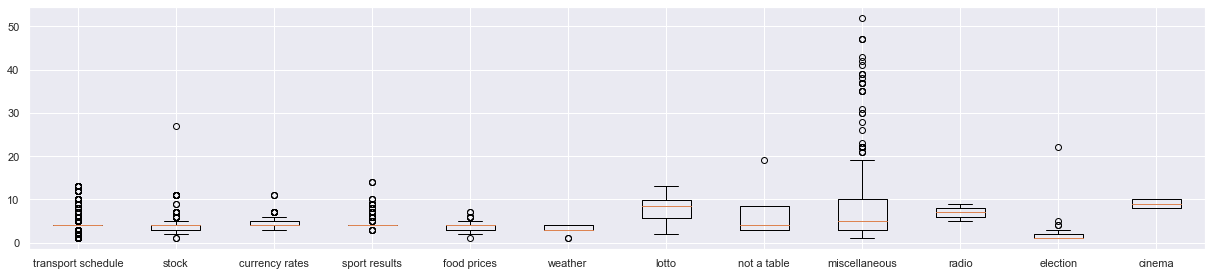

In [21]:
boxplots_data = []
for tag in tagset:
    boxplots_data.append(df.loc[df['tag'] == tag, 'page'])

plt.figure(figsize=(17,4))
plt.boxplot(boxplots_data, labels=tagset)
plt.tight_layout()
plt.show()